**We run below codes on GPU server!!**
- linux command + using argparser
- The nohup command was used so that model learning was also performed in the GPU server background.
- We wanted to compare the three methods of Data Augmentation (Salience Mix+Traditional, CutOut+Traditional, and Traditional only).
- reference : https://github.com/afm-shahab-uddin/SaliencyMix  /  https://github.com/uoguelph-mlrg/Cutout

# 0. git clone

SaliencyMix files

In [ ]:
!git clone https://github.com/afm-shahab-uddin/SaliencyMix.git

clone result => 
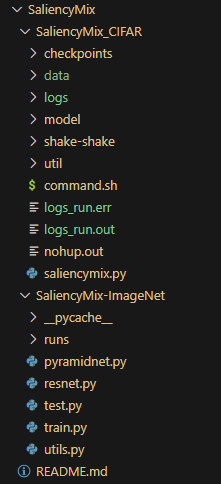

Cutout files

In [ ]:
!git clone https://github.com/uoguelph-mlrg/Cutout.git

clone result => 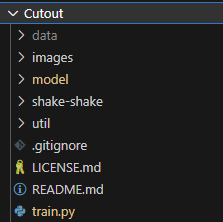

# 1. SaliencyMix

**command**

-To train ResNet18 on CIFAR10 with SaliencyMix and traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=3 nohup python SaliencyMix/SaliencyMix_CIFAR/saliencymix.py 
--dataset cifar10 
--model resnet18 
--beta 1.0 
--salmix_prob 0.5 
--batch_size 128 
--data_augmentation 
--learning_rate 0.1 
> /home/pbl9/group10/results/logs/cifar10_resnet18_saliencymix.log 2>&1 &
```

-To train ResNet50 on CIFAR10 with SaliencyMix and traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=3 nohup python SaliencyMix/SaliencyMix_CIFAR/saliencymix.py 
--dataset cifar10 
--model resnet50 
--beta 1.0 
--salmix_prob 0.5 
--batch_size 128 
--data_augmentation
--learning_rate 0.1 
> /home/pbl9/group10/results/logs/cifar10_resnet50_saliencymix.log 2>&1 &
```

-To train WideResNet on CIFAR10 with SaliencyMix and traditional data augmentation:

```
CUDA_VISIBLE_DEVICES=3 nohup python SaliencyMix/SaliencyMix_CIFAR/saliencymix.py 
--dataset cifar10 
--model wideresnet
--beta 1.0 
--salmix_prob 0.5 
--batch_size 128 
--data_augmentation 
--learning_rate 0.1 
> /home/pbl9/group10/results/logs/cifar10_wideresnet_saliencymix.log 2>&1 &
```


## saliencymix.py

In [ ]:
# This is the train code to use saliency mix data augmentation for CIFAR dataset

import pdb
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms

from util.misc import CSVLogger

from model.resnet import ResNet18, ResNet50, ResNet101
from model.wide_resnet import WideResNet

import os
import cv2

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record() # 시간 측정

model_options = ['resnet18', 'resnet50', 'resnet101', 'wideresnet']
dataset_options = ['cifar10', 'cifar100', 'svhn']

parser = argparse.ArgumentParser(description='SaliencyMix')
parser.add_argument('--dataset', '-d', default='cifar10',
                    choices=dataset_options)
parser.add_argument('--model', '-a', default='resnet18',
                    choices=model_options)
parser.add_argument('--batch_size', type=int, default=128,
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='learning rate')
parser.add_argument('--data_augmentation', action='store_true', default=False,
                    help='augment data by flipping and cropping')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=0,
                    help='random seed (default: 1)')
parser.add_argument('--beta', default=1, type=float,
                    help='hyperparameter beta')
parser.add_argument('--salmix_prob', default=0.5, type=float,
                    help='SaliencyMix probability')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

test_id = args.dataset + '_' + args.model

print(args)

# Image Preprocessing
if args.dataset == 'svhn':
    normalize = transforms.Normalize(mean=[x / 255.0 for x in[109.9, 109.7, 113.8]],
                                     std=[x / 255.0 for x in [50.1, 50.6, 50.8]])
else:
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if args.data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

if args.dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif args.dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)
elif args.dataset == 'svhn':
    num_classes = 10
    train_dataset = datasets.SVHN(root='data/',
                                  split='train',
                                  transform=train_transform,
                                  download=True)

    extra_dataset = datasets.SVHN(root='data/',
                                  split='extra',
                                  transform=train_transform,
                                  download=True)

    # Combine both training splits (https://arxiv.org/pdf/1605.07146.pdf)
    data = np.concatenate([train_dataset.data, extra_dataset.data], axis=0)
    labels = np.concatenate([train_dataset.labels, extra_dataset.labels], axis=0)
    train_dataset.data = data
    train_dataset.labels = labels

    test_dataset = datasets.SVHN(root='data/',
                                 split='test',
                                 transform=test_transform,
                                 download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

if args.model == 'resnet18':
    cnn = ResNet18(num_classes=num_classes)
elif args.model == 'resnet50':
    cnn = ResNet50(num_classes=num_classes)
elif args.model == 'resnet101':
    cnn = ResNet101(num_classes=num_classes)
elif args.model == 'wideresnet':
    if args.dataset == 'svhn':
        cnn = WideResNet(depth=16, num_classes=num_classes, widen_factor=8,
                         dropRate=0.4)
    else:
        cnn = WideResNet(depth=28, num_classes=num_classes, widen_factor=10,
                         dropRate=0.3)

# cnn = cnn.cuda()
cnn = nn.DataParallel(cnn).cuda()
criterion = nn.CrossEntropyLoss().cuda()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)

if args.dataset == 'svhn':
    scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)
else:
    scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)


# # Create logs Directory if does exist
# if not os.path.exists('logs'):
#     os.mkdir('logs')
filename = 'results/csv_results/' + test_id + '.csv'
csv_logger = CSVLogger(args=args, fieldnames=['epoch', 'train_acc', 'test_acc'], filename=filename)


def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            pred = cnn(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = (correct / total)*100
    cnn.train()
    return val_acc


def saliency_bbox(img, lam):
    size = img.size()
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and
    # compute the saliency map
    temp_img = img.cpu().numpy().transpose(1, 2, 0)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(temp_img)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
    x = maximum_indices[0]
    y = maximum_indices[1]

    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


best_accuracy = 0
best_acc_epoch = 0

for epoch in range(args.epochs):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        images = images.cuda()
        labels = labels.cuda()

        r = np.random.rand(1)
        if args.beta > 0 and r < args.salmix_prob:
            # generate mixed sample
            lam = np.random.beta(args.beta, args.beta)
            rand_index = torch.randperm(images.size()[0]).cuda()
            labels_a = labels
            labels_b = labels[rand_index]
            bbx1, bby1, bbx2, bby2 = saliency_bbox(images[rand_index[0]], lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))

            # compute output
            cnn.zero_grad()
            pred = cnn(images)
            xentropy_loss = criterion(pred, labels_a)* lam + criterion(pred, labels_b) * (1. - lam)
        else:
            cnn.zero_grad()
            pred = cnn(images)
            xentropy_loss = criterion(pred, labels)

        xentropy_loss.backward()
        cnn_optimizer.step()

        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = (correct / total)*100

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    scheduler.step(epoch)

    row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    csv_logger.writerow(row)

    if(test_acc>best_accuracy):
        best_accuracy = test_acc
        best_acc_epoch = epoch

end.record()
torch.cuda.synchronize()
f = open("/home/pbl9/group10/results/running_time/" + test_id + ".txt", "w")
f. write(f'trainig time : {start.elapsed_time(end)}')

torch.save(cnn.state_dict(), '/home/pbl9/group10/results/checkpoints/' + test_id + '.pt')
csv_logger.close()

f = open("best_accuracy.txt", "a+")
f .write('best acc: %.3f at iteration: %d \r\n' % (best_accuracy, best_acc_epoch))
f.close()


## logs

**⚠️The log is too long, so the middle part is omitted. We ask for your understanding of this.**


### cifar10_resnet18_saliencymix.log





```
nohup: ignoring input
Namespace(dataset='cifar10', model='resnet18', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, no_cuda=False, seed=0, beta=1.0, salmix_prob=0.5, cuda=True)
Files already downloaded and verified
Files already downloaded and verified
  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:01<?, ?it/s, acc=10.938, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=10.938, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=10.938, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=13.281, xentropy=3.425]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=13.281, xentropy=3.425]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=12.760, xentropy=4.009]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=12.760, xentropy=4.009]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=11.719, xentropy=5.560]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=11.719, xentropy=5.560]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=12.031, xentropy=5.724]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=12.031, xentropy=5.724]
Epoch 0:   0%|          | 1/391 [00:01<09:53,  1.52s/it, acc=11.328, xentropy=6.141]
Epoch 0:   2%|▏         | 6/391 [00:01<01:19,  4.85it/s, acc=11.328, xentropy=6.141]
Epoch 0:   2%|▏         | 6/391 [00:01<01:19,  4.85it/s, acc=11.328, xentropy=6.141]

.
.
.


Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.594, xentropy=0.368]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.548, xentropy=0.370]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.548, xentropy=0.370]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.572, xentropy=0.369]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.572, xentropy=0.369]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.558, xentropy=0.370]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.558, xentropy=0.370]
Epoch 199:  98%|█████████▊| 383/391 [00:10<00:00, 37.74it/s, acc=90.583, xentropy=0.369]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.583, xentropy=0.369]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.583, xentropy=0.369]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.607, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.607, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.631, xentropy=0.369]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.631, xentropy=0.369]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.629, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.629, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:10<00:00, 35.66it/s, acc=90.644, xentropy=0.369]
Epoch 199: 100%|██████████| 391/391 [00:10<00:00, 34.99it/s, acc=90.644, xentropy=0.369]
Epoch 199: 100%|██████████| 391/391 [00:10<00:00, 36.63it/s, acc=90.644, xentropy=0.369]
test_acc: 95.840
```

### cifar10_resnet50_saliencymix.log



```
nohup: ignoring input
Namespace(dataset='cifar10', model='resnet50', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, no_cuda=False, seed=0, beta=1.0, salmix_prob=0.5, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:03<?, ?it/s, acc=7.812, xentropy=2.392]
Epoch 0:   0%|          | 1/391 [00:03<23:48,  3.66s/it, acc=7.812, xentropy=2.392]
Epoch 0:   0%|          | 1/391 [00:03<23:48,  3.66s/it, acc=7.812, xentropy=2.392]
Epoch 0:   0%|          | 1/391 [00:03<23:48,  3.66s/it, acc=9.375, xentropy=12.980]
Epoch 0:   0%|          | 1/391 [00:03<23:48,  3.66s/it, acc=9.375, xentropy=12.980]
Epoch 0:   0%|          | 1/391 [00:03<23:48,  3.66s/it, acc=10.677, xentropy=15.733]
Epoch 0:   1%|          | 3/391 [00:03<06:26,  1.00it/s, acc=10.677, xentropy=15.733]
Epoch 0:   1%|          | 3/391 [00:03<06:26,  1.00it/s, acc=10.677, xentropy=15.733]
Epoch 0:   1%|          | 3/391 [00:03<06:26,  1.00it/s, acc=9.961, xentropy=13.758] 
Epoch 0:   1%|          | 3/391 [00:03<06:26,  1.00it/s, acc=9.961, xentropy=13.758]
Epoch 0:   1%|          | 3/391 [00:03<06:26,  1.00it/s, acc=9.688, xentropy=12.271]
Epoch 0:   1%|▏         | 5/391 [00:03<03:20,  1.92it/s, acc=9.688, xentropy=12.271]
Epoch 0:   1%|▏         | 5/391 [00:03<03:20,  1.92it/s, acc=9.688, xentropy=12.271]
Epoch 0:   1%|▏         | 5/391 [00:04<03:20,  1.92it/s, acc=9.766, xentropy=16.810]

.
.
.


Epoch 199:  98%|█████████▊| 383/391 [00:23<00:00, 17.02it/s, acc=90.273, xentropy=0.370]
Epoch 199:  98%|█████████▊| 383/391 [00:23<00:00, 17.02it/s, acc=90.292, xentropy=0.371]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.95it/s, acc=90.292, xentropy=0.371]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.95it/s, acc=90.292, xentropy=0.371]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.95it/s, acc=90.313, xentropy=0.371]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.95it/s, acc=90.313, xentropy=0.371]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.95it/s, acc=90.338, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.55it/s, acc=90.338, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.55it/s, acc=90.338, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.55it/s, acc=90.363, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.55it/s, acc=90.363, xentropy=0.370]
Epoch 199:  99%|█████████▉| 387/391 [00:24<00:00, 16.55it/s, acc=90.388, xentropy=0.369]
Epoch 199:  99%|█████████▉| 389/391 [00:24<00:00, 16.47it/s, acc=90.388, xentropy=0.369]
Epoch 199:  99%|█████████▉| 389/391 [00:24<00:00, 16.47it/s, acc=90.388, xentropy=0.369]
Epoch 199:  99%|█████████▉| 389/391 [00:24<00:00, 16.47it/s, acc=90.413, xentropy=0.368]
Epoch 199:  99%|█████████▉| 389/391 [00:24<00:00, 16.47it/s, acc=90.413, xentropy=0.368]
Epoch 199:  99%|█████████▉| 389/391 [00:24<00:00, 16.47it/s, acc=90.426, xentropy=0.368]
Epoch 199: 100%|██████████| 391/391 [00:24<00:00, 17.01it/s, acc=90.426, xentropy=0.368]
Epoch 199: 100%|██████████| 391/391 [00:24<00:00, 16.16it/s, acc=90.426, xentropy=0.368]
test_acc: 95.960
```



### cifar10_wideresnet_saliencymix.log



```
nohup: ignoring input
Namespace(dataset='cifar10', model='wideresnet', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, no_cuda=False, seed=0, beta=1.0, salmix_prob=0.5, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:02<?, ?it/s, acc=9.375, xentropy=2.318]
Epoch 0:   0%|          | 1/391 [00:02<17:19,  2.67s/it, acc=9.375, xentropy=2.318]
Epoch 0:   0%|          | 1/391 [00:02<17:19,  2.67s/it, acc=9.375, xentropy=2.318]
Epoch 0:   0%|          | 1/391 [00:02<17:19,  2.67s/it, acc=11.719, xentropy=2.326]
Epoch 0:   0%|          | 1/391 [00:02<17:19,  2.67s/it, acc=11.719, xentropy=2.326]
Epoch 0:   0%|          | 1/391 [00:02<17:19,  2.67s/it, acc=11.458, xentropy=2.345]
Epoch 0:   1%|          | 3/391 [00:02<04:55,  1.31it/s, acc=11.458, xentropy=2.345]
Epoch 0:   1%|          | 3/391 [00:02<04:55,  1.31it/s, acc=11.458, xentropy=2.345]
Epoch 0:   1%|          | 3/391 [00:02<04:55,  1.31it/s, acc=11.328, xentropy=2.390]
Epoch 0:   1%|          | 4/391 [00:02<03:27,  1.87it/s, acc=11.328, xentropy=2.390]
Epoch 0:   1%|          | 4/391 [00:02<03:27,  1.87it/s, acc=11.328, xentropy=2.390]
Epoch 0:   1%|          | 4/391 [00:03<03:27,  1.87it/s, acc=11.094, xentropy=2.389]
Epoch 0:   1%|          | 4/391 [00:03<03:27,  1.87it/s, acc=11.094, xentropy=2.389]
Epoch 0:   1%|          | 4/391 [00:03<03:27,  1.87it/s, acc=11.849, xentropy=2.384]


.
.
.


Epoch 199:  98%|█████████▊| 384/391 [00:39<00:00, 10.03it/s, acc=89.341, xentropy=0.343]
Epoch 199:  98%|█████████▊| 384/391 [00:39<00:00, 10.03it/s, acc=89.369, xentropy=0.342]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00,  9.95it/s, acc=89.369, xentropy=0.342]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00,  9.95it/s, acc=89.369, xentropy=0.342]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00,  9.95it/s, acc=89.394, xentropy=0.343]
Epoch 199:  99%|█████████▊| 386/391 [00:39<00:00,  9.93it/s, acc=89.394, xentropy=0.343]
Epoch 199:  99%|█████████▊| 386/391 [00:39<00:00,  9.93it/s, acc=89.394, xentropy=0.343]
Epoch 199:  99%|█████████▊| 386/391 [00:39<00:00,  9.93it/s, acc=89.422, xentropy=0.342]
Epoch 199:  99%|█████████▊| 386/391 [00:39<00:00,  9.93it/s, acc=89.422, xentropy=0.342]
Epoch 199:  99%|█████████▊| 386/391 [00:39<00:00,  9.93it/s, acc=89.240, xentropy=0.344]
Epoch 199:  99%|█████████▉| 388/391 [00:39<00:00, 10.01it/s, acc=89.240, xentropy=0.344]
Epoch 199:  99%|█████████▉| 388/391 [00:39<00:00, 10.01it/s, acc=89.240, xentropy=0.344]
Epoch 199:  99%|█████████▉| 388/391 [00:39<00:00, 10.01it/s, acc=89.267, xentropy=0.343]
Epoch 199:  99%|█████████▉| 388/391 [00:39<00:00, 10.01it/s, acc=89.267, xentropy=0.343]
Epoch 199:  99%|█████████▉| 388/391 [00:39<00:00, 10.01it/s, acc=89.295, xentropy=0.342]
Epoch 199: 100%|█████████▉| 390/391 [00:39<00:00, 10.13it/s, acc=89.295, xentropy=0.342]
Epoch 199: 100%|█████████▉| 390/391 [00:39<00:00, 10.13it/s, acc=89.295, xentropy=0.342]
Epoch 199: 100%|█████████▉| 390/391 [00:40<00:00, 10.13it/s, acc=89.312, xentropy=0.341]
Epoch 199: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, acc=89.312, xentropy=0.341]
test_acc: 97.190
```



# 2. CutOut

**command**

-To train ResNet18 on CIFAR10 with CutOut and traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model resnet18  
--data_augmentation
--cutout 
> /home/pbl9/group10/results/logs/cifar10_resnet18_cutout.log 2>&1 &
```

-To train ResNet50 on CIFAR10 with CutOut and traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model resnet50  
--data_augmentation 
--cutout 
> /home/pbl9/group10/results/logs/cifar10_resnet50_cutout.log 2>&1 &
```

-To train WideResNet on CIFAR10 with CutOut and traditional data augmentation:

```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model wideresnet  
--data_augmentation 
--cutout 
> /home/pbl9/group10/results/logs/cifar10_wideresnet_cutout.log 2>&1 &
```


## train.py

In [ ]:
# This train code is used for make models of Cutout and baseline.

# train command example
# For make baseline(only traditional data augmentation appied) model,
# nohup python Cutout/train.py --dataset cifar10 --model wideresnet  --data_augmentation > /home/pbl9/group10/results/logs/cifar10_wideresnet_baseline_new.log 2>&1 &
# nohup python Cutout/train.py --dataset cifar10 --model resnet50 --data_augmentation > /home/pbl9/group10/results/logs/cifar10_resnet50_baseline_new.log 2>&1 &


import pdb
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision.utils import make_grid
from torchvision import datasets, transforms

from util.misc import CSVLogger
from util.cutout import Cutout

from model.resnet import ResNet18, ResNet50  # modify here to add ResNet50
from model.wide_resnet import WideResNet

# add 'resnet50' here for our experiment
model_options = ['resnet18', 'wideresnet', 'resnet50']
dataset_options = ['cifar10', 'cifar100', 'svhn']

# this is for train command options
parser = argparse.ArgumentParser(description='CNN')
parser.add_argument('--dataset', '-d', default='cifar10',
                    choices=dataset_options)
parser.add_argument('--model', '-a', default='resnet18',
                    choices=model_options)
parser.add_argument('--batch_size', type=int, default=128,
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of epochs to train (default: 200)')
parser.add_argument('--learning_rate', type=float, default=0.1,
                    help='learning rate')
parser.add_argument('--data_augmentation', action='store_true', default=False,
                    help='augment data by flipping and cropping')
parser.add_argument('--cutout', action='store_true', default=False,
                    help='apply cutout')
parser.add_argument('--n_holes', type=int, default=1,
                    help='number of holes to cut out from image')
parser.add_argument('--length', type=int, default=16,
                    help='length of the holes')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=0,
                    help='random seed (default: 1)')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# path to save the results
test_id = args.dataset + '_' + args.model + 'baseline_new'

print(args)

############################################  Image Preprocessing  ############################################
if args.dataset == 'svhn':
    normalize = transforms.Normalize(mean=[x / 255.0 for x in[109.9, 109.7, 113.8]],
                                     std=[x / 255.0 for x in [50.1, 50.6, 50.8]])
# Normalize for CIFAR-10
else:
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
# add augmentation when data_augmentation is set to True
if args.data_augmentation:
    # apply cropping and flipping (traditional data augmentation)
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
# transform to tensor
train_transform.transforms.append(transforms.ToTensor())
# add normalize
train_transform.transforms.append(normalize)

# add cutout when cutout is set to True
if args.cutout:
    train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length))


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

############################################ Load dataset ############################################

# download data depending on the dataset that we want to use
if args.dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif args.dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)

# Data Loader (Input Pipeline)
# apply our batch size and shuffle data here
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=args.batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)



############################################ Load models ############################################

if args.model == 'resnet18':
    cnn = ResNet18(num_classes=num_classes)
# Added here for resnet50
elif args.model == 'resnet50':
    cnn = ResNet50(num_classes=num_classes)
elif args.model == 'wideresnet':
    if args.dataset == 'svhn':
        cnn = WideResNet(depth=16, num_classes=num_classes, widen_factor=8,
                         dropRate=0.4)
    else:
        cnn = WideResNet(depth=28, num_classes=num_classes, widen_factor=10,
                         dropRate=0.3)


############################################ Define loss function and optimizer ############################################

# load model to GPU
cnn = cnn.cuda()
# define loss function
criterion = nn.CrossEntropyLoss().cuda()
# define optimizer 
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate,
                                momentum=0.9, nesterov=True, weight_decay=5e-4)


############################################ Set learning rate scheduler ############################################

# set learning rate scheduler option
if args.dataset == 'svhn':
    scheduler = MultiStepLR(cnn_optimizer, milestones=[80, 120], gamma=0.1)
else:
    scheduler = MultiStepLR(cnn_optimizer, milestones=[60, 120, 160], gamma=0.2)
    
    
############################################ Training ############################################

# to save the logs to the path 
filename = 'results/csv_results/' + test_id + '.csv'
csv_logger = CSVLogger(args=args, fieldnames=['epoch', 'train_acc', 'test_acc'], filename=filename)

# test function to calculate test accuracy for each epoch
def test(loader):
    cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0.
    total = 0.
    for images, labels in loader:
        # set images and labels on cuda 
        images = images.cuda()
        labels = labels.cuda()

        # get the result of test set
        with torch.no_grad():
            pred = cnn(images)

        # classified label of our model
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        # Add to correct if the result is right with the real label
        correct += (pred == labels).sum().item()

    # Calculate validation accuracy 
    val_acc = correct / total
    # Change to train mode to continue next train 
    cnn.train()
    return val_acc

# Training loop
for epoch in range(args.epochs):

    xentropy_loss_avg = 0.
    correct = 0.
    total = 0.

    # to show process of training visually 
    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        progress_bar.set_description('Epoch ' + str(epoch))

        # Make images and labels on gpu 
        images = images.cuda()
        labels = labels.cuda()

        cnn.zero_grad()
        # Get output from model 
        pred = cnn(images)  

        # Calculate loss with loss function and backward pass
        xentropy_loss = criterion(pred, labels)
        xentropy_loss.backward()
        cnn_optimizer.step()

        # Accumulate loss
        xentropy_loss_avg += xentropy_loss.item()

        # Calculate running average of accuracy
        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels.data).sum().item()
        accuracy = correct / total

        progress_bar.set_postfix(
            xentropy='%.3f' % (xentropy_loss_avg / (i + 1)),
            acc='%.3f' % accuracy)

    # Calculate test accuracy 
    test_acc = test(test_loader)
    tqdm.write('test_acc: %.3f' % (test_acc))

    #scheduler.step(epoch)  # Use this line for PyTorch <1.4
    scheduler.step()     # Use this line for PyTorch >=1.4 
                        # we used pytorch 2.0.1 so the second option is used 

    row = {'epoch': str(epoch), 'train_acc': str(accuracy), 'test_acc': str(test_acc)}
    csv_logger.writerow(row)

# Save the checkpoint 
torch.save(cnn.state_dict(), 'results/checkpoints/' + test_id + '.pt')
csv_logger.close()


## logs


### cifar10_resnet18_cutout.log





```
nohup: ignoring input
Namespace(dataset='cifar10', model='resnet18', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=True, n_holes=1, length=16, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s, acc=0.102, xentropy=2.356]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.102, xentropy=2.356]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.102, xentropy=2.356]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.129, xentropy=3.460]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.129, xentropy=3.460]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.122, xentropy=3.880]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.122, xentropy=3.880]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.127, xentropy=5.950]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.127, xentropy=5.950]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.123, xentropy=5.639]
Epoch 0:   0%|          | 1/391 [00:00<03:34,  1.82it/s, acc=0.123, xentropy=5.639]

.
.
.

Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.029]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.029]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.029]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.029]
Epoch 199:  98%|█████████▊| 382/391 [00:08<00:00, 44.02it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199:  99%|█████████▉| 387/391 [00:08<00:00, 44.60it/s, acc=0.991, xentropy=0.029]
Epoch 199: 100%|██████████| 391/391 [00:08<00:00, 43.51it/s, acc=0.991, xentropy=0.029]
test_acc: 0.960
```




### cifar10_resnet50_cutout.log





```
Namespace(dataset='cifar10', model='resnet50', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=True, n_holes=1, length=16, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:01<?, ?it/s, acc=0.078, xentropy=2.401]
Epoch 0:   0%|          | 1/391 [00:01<07:04,  1.09s/it, acc=0.078, xentropy=2.401]
Epoch 0:   0%|          | 1/391 [00:01<07:04,  1.09s/it, acc=0.078, xentropy=2.401]
Epoch 0:   0%|          | 1/391 [00:01<07:04,  1.09s/it, acc=0.094, xentropy=11.714]
Epoch 0:   0%|          | 1/391 [00:01<07:04,  1.09s/it, acc=0.094, xentropy=11.714]
Epoch 0:   0%|          | 1/391 [00:01<07:04,  1.09s/it, acc=0.107, xentropy=16.901]
Epoch 0:   1%|          | 3/391 [00:01<02:08,  3.03it/s, acc=0.107, xentropy=16.901]
Epoch 0:   1%|          | 3/391 [00:01<02:08,  3.03it/s, acc=0.107, xentropy=16.901]
Epoch 0:   1%|          | 3/391 [00:01<02:08,  3.03it/s, acc=0.100, xentropy=20.551]
Epoch 0:   1%|          | 3/391 [00:01<02:08,  3.03it/s, acc=0.100, xentropy=20.551]
Epoch 0:   1%|          | 3/391 [00:01<02:08,  3.03it/s, acc=0.095, xentropy=21.142]
Epoch 0:   1%|▏         | 5/391 [00:01<01:13,  5.22it/s, acc=0.095, xentropy=21.142]


.
.
.

Epoch 199:  98%|█████████▊| 383/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 383/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 383/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  98%|█████████▊| 385/391 [00:23<00:00, 16.57it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.37it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.37it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.37it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.37it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 387/391 [00:23<00:00, 16.37it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 389/391 [00:23<00:00, 16.43it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 389/391 [00:23<00:00, 16.43it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 389/391 [00:23<00:00, 16.43it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 389/391 [00:23<00:00, 16.43it/s, acc=0.991, xentropy=0.028]
Epoch 199:  99%|█████████▉| 389/391 [00:23<00:00, 16.43it/s, acc=0.991, xentropy=0.028]
Epoch 199: 100%|██████████| 391/391 [00:23<00:00, 16.31it/s, acc=0.991, xentropy=0.028]
test_acc: 0.960
5117202.5
```
* The last line represents the time of code execution.



### cifar10_wideresnet_cutout.log





```
Namespace(dataset='cifar10', model='wideresnet', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=True, n_holes=1, length=16, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s, acc=0.117, xentropy=2.310]
Epoch 0:   0%|          | 1/391 [00:00<05:03,  1.28it/s, acc=0.117, xentropy=2.310]
Epoch 0:   0%|          | 1/391 [00:00<05:03,  1.28it/s, acc=0.117, xentropy=2.310]
Epoch 0:   0%|          | 1/391 [00:00<05:03,  1.28it/s, acc=0.125, xentropy=2.309]
Epoch 0:   0%|          | 1/391 [00:00<05:03,  1.28it/s, acc=0.125, xentropy=2.309]
Epoch 0:   0%|          | 1/391 [00:00<05:03,  1.28it/s, acc=0.120, xentropy=2.325]
Epoch 0:   1%|          | 3/391 [00:00<01:41,  3.81it/s, acc=0.120, xentropy=2.325]
Epoch 0:   1%|          | 3/391 [00:00<01:41,  3.81it/s, acc=0.120, xentropy=2.325]
Epoch 0:   1%|          | 3/391 [00:01<01:41,  3.81it/s, acc=0.117, xentropy=2.381]
Epoch 0:   1%|          | 3/391 [00:01<01:41,  3.81it/s, acc=0.117, xentropy=2.381]
Epoch 0:   1%|          | 3/391 [00:01<01:41,  3.81it/s, acc=0.122, xentropy=2.391]
Epoch 0:   1%|▏         | 5/391 [00:01<01:05,  5.92it/s, acc=0.122, xentropy=2.391]

.
.
.

Epoch 199:  98%|█████████▊| 383/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  98%|█████████▊| 385/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  98%|█████████▊| 385/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  98%|█████████▊| 385/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  98%|█████████▊| 385/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  98%|█████████▊| 385/391 [00:31<00:00, 12.28it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 387/391 [00:31<00:00, 12.19it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 387/391 [00:31<00:00, 12.19it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 387/391 [00:31<00:00, 12.19it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 387/391 [00:31<00:00, 12.19it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 387/391 [00:31<00:00, 12.19it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 389/391 [00:31<00:00, 12.20it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 389/391 [00:31<00:00, 12.20it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 389/391 [00:31<00:00, 12.20it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 389/391 [00:31<00:00, 12.20it/s, acc=0.993, xentropy=0.023]
Epoch 199:  99%|█████████▉| 389/391 [00:32<00:00, 12.20it/s, acc=0.993, xentropy=0.023]
Epoch 199: 100%|██████████| 391/391 [00:32<00:00, 12.93it/s, acc=0.993, xentropy=0.023]
Epoch 199: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s, acc=0.993, xentropy=0.023]
test_acc: 0.970
6849382.5
```
* The last line represents the time of code execution.

# 3. Traditional only (Baseline)

**command**

-To train ResNet18 on CIFAR10 with traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model resnet18  
--data_augmentation 
> /home/pbl9/group10/results/logs/cifar10_resnet18_baseline.log 2>&1 &
```

-To train ResNet50 on CIFAR10 with traditional data augmentation:
```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model resnet50  
--data_augmentation 
> /home/pbl9/group10/results/logs/cifar10_resnet50_baseline.log 2>&1 &
```

-To train WideResNet on CIFAR10 with traditional data augmentation:

```
CUDA_VISIBLE_DEVICES=2 nohup python Cutout/train.py 
--dataset cifar10 
--model wideresnet  
--data_augmentation 
> /home/pbl9/group10/results/logs/cifar10_wideresnet_baseline.log 2>&1 &
```


## train.py

In [ ]:
# same as the above training code (in CutOut)

## logs


### cifar10_resnet18_baseline.log





```
nohup: ignoring input
Namespace(dataset='cifar10', model='resnet18', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=False, n_holes=1, length=16, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:03<?, ?it/s, acc=0.109, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.109, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.109, xentropy=2.353]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.133, xentropy=3.426]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.133, xentropy=3.426]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.130, xentropy=4.009]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.130, xentropy=4.009]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.119, xentropy=5.533]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.119, xentropy=5.533]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.125, xentropy=5.720]
Epoch 0:   0%|          | 1/391 [00:03<21:36,  3.32s/it, acc=0.125, xentropy=5.720]

.
.
.

Epoch 199:  98%|█████████▊| 383/391 [00:21<00:00, 17.93it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 383/391 [00:21<00:00, 17.93it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 383/391 [00:21<00:00, 17.93it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 383/391 [00:21<00:00, 17.93it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:21<00:00, 17.57it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:21<00:00, 17.57it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:21<00:00, 17.57it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:21<00:00, 17.57it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:21<00:00, 17.57it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:21<00:00, 17.81it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:21<00:00, 17.81it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:21<00:00, 17.81it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:21<00:00, 17.81it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:21<00:00, 17.81it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:21<00:00, 17.68it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:21<00:00, 17.68it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:21<00:00, 17.68it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:21<00:00, 17.68it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:21<00:00, 17.68it/s, acc=1.000, xentropy=0.002]
Epoch 199: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s, acc=1.000, xentropy=0.002]
test_acc: 0.953
```




### cifar10_resnet50_baseline.log





```
nohup: ignoring input
Namespace(dataset='cifar10', model='resnet50', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=False, n_holes=1, length=16, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:05<?, ?it/s, acc=0.078, xentropy=2.424]
Epoch 0:   0%|          | 1/391 [00:05<32:41,  5.03s/it, acc=0.078, xentropy=2.424]
Epoch 0:   0%|          | 1/391 [00:05<32:41,  5.03s/it, acc=0.078, xentropy=2.424]
Epoch 0:   0%|          | 1/391 [00:05<32:41,  5.03s/it, acc=0.094, xentropy=12.585]
Epoch 0:   0%|          | 1/391 [00:05<32:41,  5.03s/it, acc=0.094, xentropy=12.585]
Epoch 0:   0%|          | 1/391 [00:05<32:41,  5.03s/it, acc=0.107, xentropy=21.399]
Epoch 0:   1%|          | 3/391 [00:05<08:43,  1.35s/it, acc=0.107, xentropy=21.399]
Epoch 0:   1%|          | 3/391 [00:05<08:43,  1.35s/it, acc=0.107, xentropy=21.399]
Epoch 0:   1%|          | 3/391 [00:05<08:43,  1.35s/it, acc=0.100, xentropy=23.205]
Epoch 0:   1%|          | 3/391 [00:05<08:43,  1.35s/it, acc=0.100, xentropy=23.205]
Epoch 0:   1%|          | 3/391 [00:05<08:43,  1.35s/it, acc=0.102, xentropy=22.982]

.
.
.

Epoch 199:  98%|█████████▊| 382/391 [00:25<00:00, 12.95it/s, acc=1.000, xentropy=0.001]
Epoch 199:  98%|█████████▊| 384/391 [00:25<00:00, 12.90it/s, acc=1.000, xentropy=0.001]
Epoch 199:  98%|█████████▊| 384/391 [00:25<00:00, 12.90it/s, acc=1.000, xentropy=0.001]
Epoch 199:  98%|█████████▊| 384/391 [00:25<00:00, 12.90it/s, acc=1.000, xentropy=0.001]
Epoch 199:  98%|█████████▊| 384/391 [00:25<00:00, 12.90it/s, acc=1.000, xentropy=0.001]
Epoch 199:  98%|█████████▊| 384/391 [00:25<00:00, 12.90it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▊| 386/391 [00:25<00:00, 13.26it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▊| 386/391 [00:25<00:00, 13.26it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▊| 386/391 [00:25<00:00, 13.26it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▊| 386/391 [00:25<00:00, 13.26it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▊| 386/391 [00:25<00:00, 13.26it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▉| 388/391 [00:25<00:00, 13.97it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▉| 388/391 [00:25<00:00, 13.97it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▉| 388/391 [00:25<00:00, 13.97it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▉| 388/391 [00:25<00:00, 13.97it/s, acc=1.000, xentropy=0.001]
Epoch 199:  99%|█████████▉| 388/391 [00:25<00:00, 13.97it/s, acc=1.000, xentropy=0.001]
Epoch 199: 100%|█████████▉| 390/391 [00:25<00:00, 14.21it/s, acc=1.000, xentropy=0.001]
Epoch 199: 100%|█████████▉| 390/391 [00:25<00:00, 14.21it/s, acc=1.000, xentropy=0.001]
Epoch 199: 100%|█████████▉| 390/391 [00:25<00:00, 14.21it/s, acc=1.000, xentropy=0.001]
Epoch 199: 100%|██████████| 391/391 [00:26<00:00, 14.99it/s, acc=1.000, xentropy=0.001]
test_acc: 0.954
```




### cifar10_wideresnet_baseline.log





```
nohup: ignoring input
Namespace(dataset='cifar10', model='wideresnet', batch_size=128, epochs=200, learning_rate=0.1, data_augmentation=True, cutout=False, n_holes=1, length=20, no_cuda=False, seed=0, cuda=True)
Files already downloaded and verified
Files already downloaded and verified

  0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]
Epoch 0:   0%|          | 0/391 [00:06<?, ?it/s, acc=0.109, xentropy=2.316]
Epoch 0:   0%|          | 1/391 [00:06<43:47,  6.74s/it, acc=0.109, xentropy=2.316]
Epoch 0:   0%|          | 1/391 [00:06<43:47,  6.74s/it, acc=0.109, xentropy=2.316]
Epoch 0:   0%|          | 1/391 [00:06<43:47,  6.74s/it, acc=0.121, xentropy=2.312]
Epoch 0:   1%|          | 2/391 [00:06<18:27,  2.85s/it, acc=0.121, xentropy=2.312]
Epoch 0:   1%|          | 2/391 [00:06<18:27,  2.85s/it, acc=0.121, xentropy=2.312]
Epoch 0:   1%|          | 2/391 [00:06<18:27,  2.85s/it, acc=0.115, xentropy=2.328]
Epoch 0:   1%|          | 3/391 [00:06<10:18,  1.59s/it, acc=0.115, xentropy=2.328]
Epoch 0:   1%|          | 3/391 [00:06<10:18,  1.59s/it, acc=0.115, xentropy=2.328]
Epoch 0:   1%|          | 3/391 [00:07<10:18,  1.59s/it, acc=0.113, xentropy=2.386]
Epoch 0:   1%|          | 4/391 [00:07<06:29,  1.01s/it, acc=0.113, xentropy=2.386]

.
.
.


Epoch 199:  98%|█████████▊| 383/391 [00:38<00:00, 10.06it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 383/391 [00:38<00:00, 10.06it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 383/391 [00:39<00:00, 10.06it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00, 10.14it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00, 10.14it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00, 10.14it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00, 10.14it/s, acc=1.000, xentropy=0.002]
Epoch 199:  98%|█████████▊| 385/391 [00:39<00:00, 10.14it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:39<00:00,  9.96it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:39<00:00,  9.96it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:39<00:00,  9.96it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:39<00:00,  9.96it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 387/391 [00:39<00:00,  9.96it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:39<00:00, 10.13it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:39<00:00, 10.13it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:39<00:00, 10.13it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:39<00:00, 10.13it/s, acc=1.000, xentropy=0.002]
Epoch 199:  99%|█████████▉| 389/391 [00:39<00:00, 10.13it/s, acc=1.000, xentropy=0.002]
Epoch 199: 100%|██████████| 391/391 [00:39<00:00, 10.56it/s, acc=1.000, xentropy=0.002]
Epoch 199: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, acc=1.000, xentropy=0.002]
test_acc: 0.962
```

